In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
from scipy.optimize import brentq

# create color map to identify mf component 
fmax = 5/2
norm = mpl.colors.Normalize(vmin=-fmax, vmax=fmax)
cmap = cm.copper
m = cm.ScalarMappable(norm=norm, cmap=cmap)

from lightshifts.consts import h, hbar, c, eps0
from lightshifts.auxiliary import smart_gen_array, laser_intensity
import lightshifts.lightshift_solver as ls

## Calculate potential for the clock states 1S0, 3P0 and for 3P1

** Transitions relevant for clock states and intercombination line light shift **

In [4]:
#import transition data
ls_1S0 = ls('atom_yb173.json', 'transitions_1S0.json')
ls_3P0 = ls('atom_yb173.json', 'transitions_3P0.json')
ls_3P1 = ls('atom_yb173.json', 'transitions_3P1.json')

** find magic wavelength **

In [5]:
lambda_m = brentq(lambda w: ls_3P0.scalar_polarizability(w) \
       - ls_1S0.scalar_polarizability(w), 660*1e-9, 800*1e-9)
print('magic wavelength is %1.2f nm'%(lambda_m*1e9))

magic wavelength is 723.99 nm


lattice depth there in kHz/(W/cm^2)

In [6]:
print('lattice depth is %1.2f Hz/(W/cm^2)'%ls_1S0.scalar_lightshift(lambda_m))

lattice depth is -8.90 Hz/(W/cm^2)


for a given laser beam (L3)

In [7]:
laser_power = 100e-3 #in Watts
beam_waist  = 127e-6 #in meters
l_int = laser_intensity(laser_power, beam_waist)
print('lattice depth for %1.2f W/cm^2 is %1.2f Hz'%(l_int, ls_1S0.scalar_lightshift(lambda_m, l_int)))

lattice depth for 394.71 W/cm^2 is -3512.87 Hz


** SDL polarizability ratio **

In [8]:
lambda_sdl = 670e-9
ls_3P0.scalar_lightshift(lambda_sdl)/ls_1S0.scalar_lightshift(lambda_sdl)

3.00761751831238

**Yellow probe light shift** 

In [9]:
lambda_clock = 578e-9
clock_laser_intensity = laser_intensity(laser_power=50e-3, beam_waist=127e-6)
probe_shift = ls_3P0.scalar_lightshift(lambda_clock, clock_laser_intensity)\
             -ls_1S0.scalar_lightshift(lambda_clock, clock_laser_intensity)

print('yellow probe shift for %1.2f W/cm^2 is %1.2f Hz'%(clock_laser_intensity, 
                                                         probe_shift))

yellow probe shift for 197.35 W/cm^2 is 3293.50 Hz


### generate light shift table for clock states and 3P1

In [10]:
lam_0 = 200e-9
lam_1 = 1900e-9
n = 400

# generate lightshift data
sing_1S0 = [x['wavelength'] for x in ls_1S0.sorted_transitions_dict(hyperfine=False)]
sing_3P0 = [x['wavelength'] for x in ls_3P0.sorted_transitions_dict(hyperfine=False)]
sing_3P1 = [x['wavelength'] for x in ls_3P1.sorted_transitions_dict(hyperfine=False)]

w_1S0, l_1S0 = smart_gen_array(lambda w: ls_1S0.scalar_lightshift(w), lam_0, lam_1, sing_1S0, n=n)
w_3P0, l_3P0 = smart_gen_array(lambda w: ls_3P0.scalar_lightshift(w), lam_0, lam_1, sing_3P0, n=n)
w_3P1, l_3P1 = smart_gen_array(lambda w: ls_3P1.scalar_lightshift(w), lam_0, lam_1, sing_3P1, n=n)

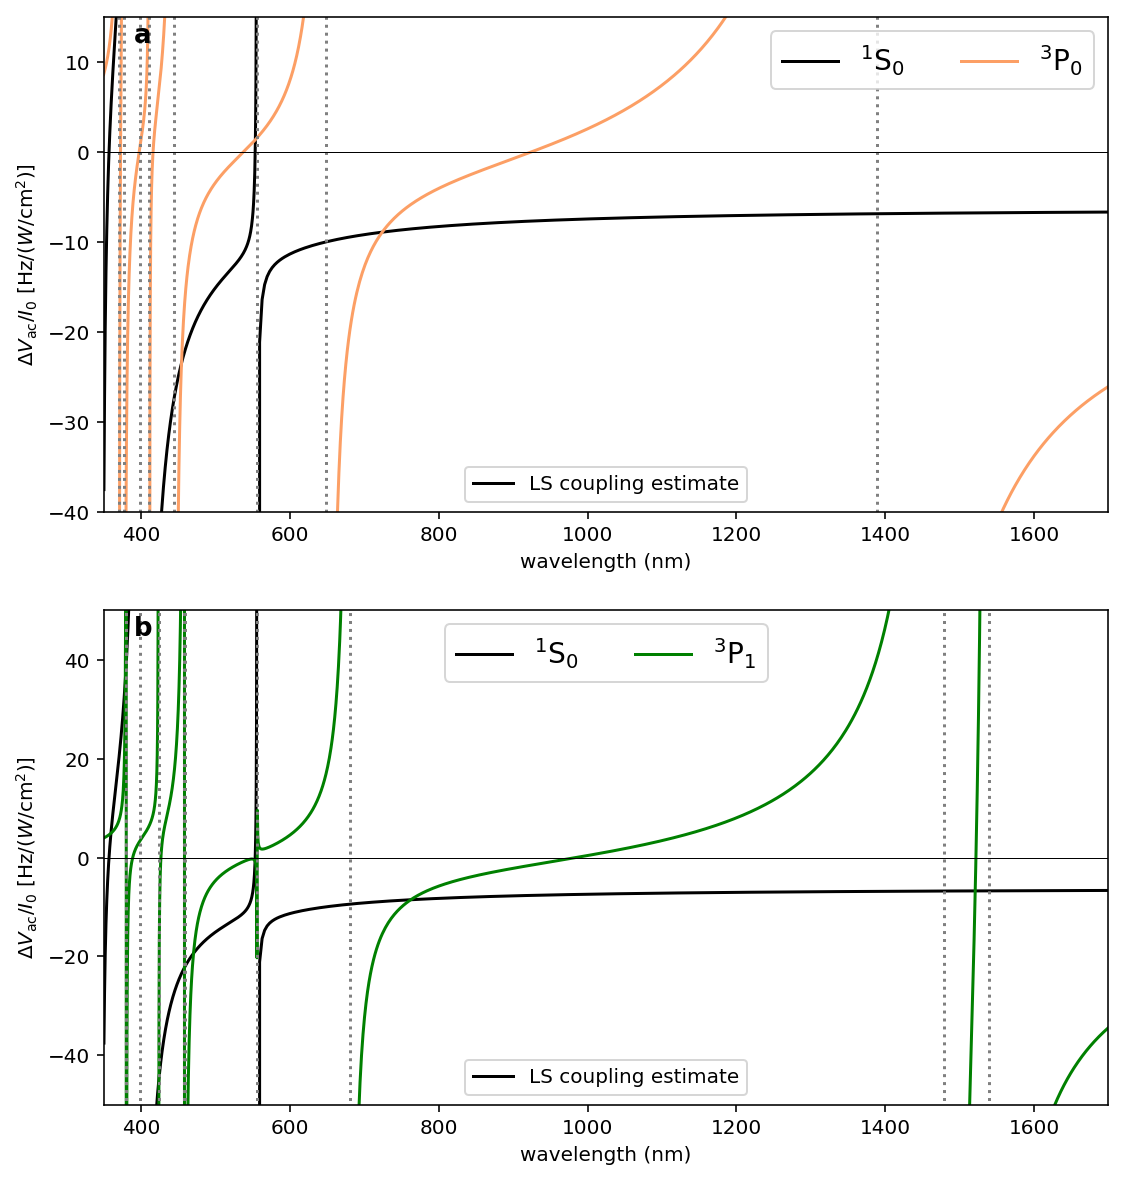

In [11]:
plt.figure(figsize=(9,10))
plt.subplot(2,1,1)

plt.text(0.03,0.95,'a',transform=plt.gca().transAxes, weight='bold', size=13)

# our calculation
la, = plt.plot(w_1S0*1e9, l_1S0, 'k', ls='-', label='LS coupling estimate')
lb, = plt.plot(w_3P0*1e9, l_3P0, c=m.to_rgba(3/2), ls='-', label='')

for sing in (sing_1S0, sing_3P0):
    for w in sing:
        plt.plot([w*1e9, w*1e9], [-1e6, 1e6], ':', color='gray')

plt.gca().axhline(y=0, color='k', lw=0.5)
plt.xlim(350,1700)
plt.ylim(-40, 15)
plt.ylabel(r'$\Delta V_\mathrm{ac}/I_0$ [Hz/($W/\mathrm{cm}^2$)]')
plt.xlabel('wavelength (nm)')
leg1 = plt.legend([la, lb], ('${}^1\mathrm{S}_0$', '${}^3\mathrm{P}_0$'), 
                  ncol=2, loc='upper right', 
                  prop={'weight':'bold', 'size':14})
plt.legend()
plt.gca().add_artist(leg1)


## 3P1 lightshift
plt.subplot(2,1,2)
plt.text(0.03,0.95,'b',transform=plt.gca().transAxes, weight='bold', size=13)

la, = plt.plot(w_1S0*1e9, l_1S0, 'k', label='LS coupling estimate')
lb, = plt.plot(w_3P1*1e9, l_3P1, c='green', label='')

for sing in (sing_1S0, sing_3P1):
    for w in sing:
        plt.plot([w*1e9, w*1e9], [-1e6, 1e6], ':', color='gray')

plt.gca().axhline(y=0, color='k', lw=0.5)
plt.xlabel('wavelength (nm)')
plt.ylabel(r'$\Delta V_\mathrm{ac}/I_0$ [Hz/($W/\mathrm{cm}^2$)]')
plt.xlim(350, 1700)
plt.ylim(-50, 50)
plt.grid(False)
leg1 = plt.legend([la, lb], ('${}^1\mathrm{S}_0$', '${}^3\mathrm{P}_1$'), 
                  ncol=2, loc='upper center', 
                  prop={'weight':'bold', 'size':14})
plt.legend()
plt.gca().add_artist(leg1)

---

# OSG ground state polarizability including vector and tensor shifts

### Transitions

In [12]:
# plot range and singularity positions
fzero = ls_1S0.transition_frequency_hyperfine(state_f=['6s6p', '3P1'], Ff=7/2)
lam_0 = c/(fzero+10e9)
lam_1 = c/(fzero-4e9)
n = 200
sing_1S0_OSG = [x['wavelength'] for x in ls_1S0.sorted_transitions_dict(hyperfine=True)]

ls_data_sig = []
for mf in np.arange(-5/2,6/2,1):
    ls_data_sig.append(smart_gen_array(lambda w: ls_1S0.total_lightshift(w, 1, mf), lam_0, lam_1, sing_1S0_OSG, n=100))    

ls_data_pi = []
for mf in np.arange(-5/2,6/2,1):
    ls_data_pi.append(smart_gen_array(lambda w: ls_1S0.total_lightshift(w, 0, mf), lam_0, lam_1, sing_1S0_OSG, n=100))    

data = {'sig': ls_data_sig, 'pi': ls_data_pi}

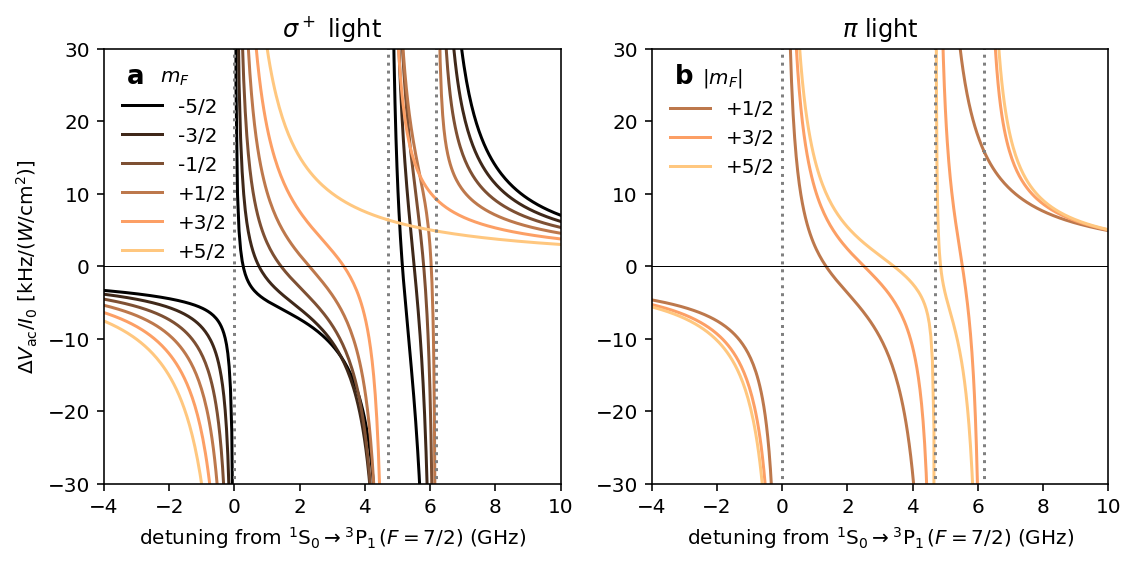

In [13]:
label = {
    'sig': 'a',
    'pi': 'b'
}

title = {
    'sig': '$\sigma^+$ light',
    'pi': '$\pi$ light'
}

legend_title = {
    'sig': '$m_F$',
    'pi': '$|m_F|$'
}

possible_mF = {
    'sig': np.arange(-5/2,6/2,1),
    'pi': np.arange(1/2, 6/2, 1)
}

plt.figure(figsize=(9,4))
for j,pol in enumerate(('sig', 'pi')):
    plt.subplot(1,2,j+1)
    for i,mf in enumerate(possible_mF[pol]):
        w,l = data[pol][i]
        plt.ylim(-100,100)
        plt.plot((c/w-fzero)/1e9, l/1e3, c=m.to_rgba(mf), label=r'{:+1.0f}/2'.format(mf*2))

    for w in sing_1S0_OSG:
        plt.plot([(c/w-fzero)/1e9, (c/w-fzero)/1e9], [-1e6, 1e6], ':', color='gray', label='')
    plt.text(0.05,0.92,label[pol],transform=plt.gca().transAxes, weight='bold', size=13)
    plt.gca().axhline(y=0, color='k', lw=0.5)
    plt.xlim(-4,10)
    plt.ylim(-30,30)
    plt.xlabel(r'detuning from $^1\mathrm{S}_0 \rightarrow ^3\mathrm{P}_1\,(F=7/2)$ (GHz)')
    if j==0:
        plt.ylabel(r'$\Delta V_\mathrm{ac}/I_0$ [kHz/($W/\mathrm{cm}^2$)]')
    plt.legend(loc='upper left',title=legend_title[pol], frameon=False)
    plt.title(title[pol])

---

# "Repumper OSG" excited clock state polarizability including vector and tensor shifts

### Transitions

In [14]:
# plot range and singularity positions
fzero = ls_3P0.transition_frequency_hyperfine(state_f=['6s5d', '3D1'], Ff=3/2)
lam_0 = c/(fzero+10e9)
lam_1 = c/(fzero-10e9)
n = 200
sing_3P0_OSG = [x['wavelength'] for x in ls_3P0.sorted_transitions_dict(hyperfine=True)]

ls_data_sig = []
for mf in np.arange(-5/2,6/2,1):
    ls_data_sig.append(smart_gen_array(lambda w: ls_3P0.total_lightshift(w, 1, mf), lam_0, lam_1, sing_3P0_OSG, n=100))    

ls_data_pi = []
for mf in np.arange(-5/2,6/2,1):
    ls_data_pi.append(smart_gen_array(lambda w: ls_3P0.total_lightshift(w, 0, mf), lam_0, lam_1, sing_3P0_OSG, n=100))    

data = {'sig': ls_data_sig, 'pi': ls_data_pi}

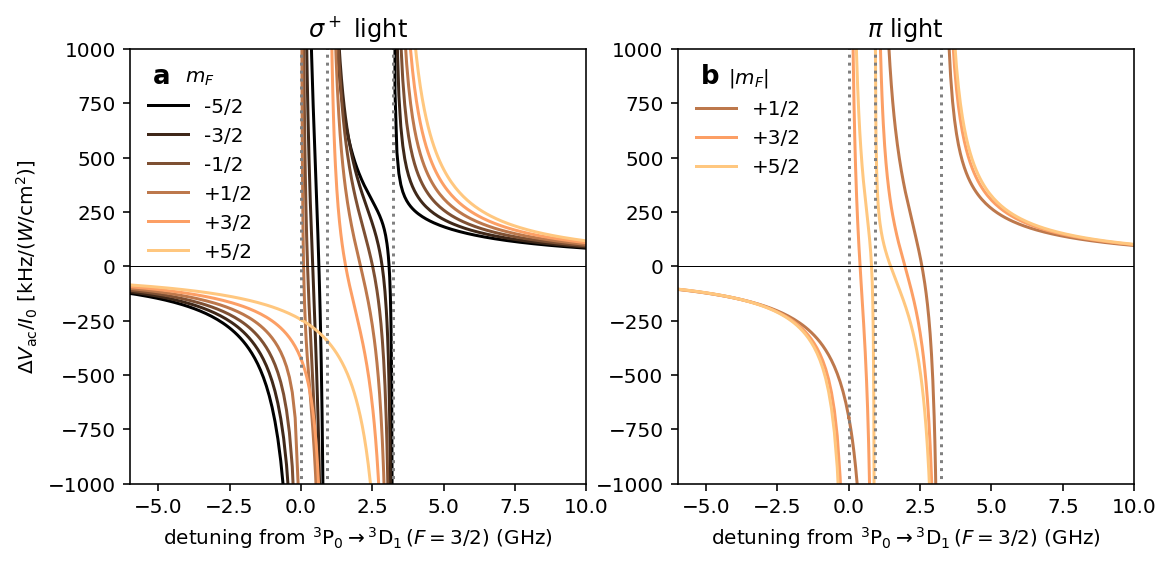

In [15]:
label = {
    'sig': 'a',
    'pi': 'b'
}

title = {
    'sig': '$\sigma^+$ light',
    'pi': '$\pi$ light'
}

legend_title = {
    'sig': '$m_F$',
    'pi': '$|m_F|$'
}

possible_mF = {
    'sig': np.arange(-5/2,6/2,1),
    'pi': np.arange(1/2, 6/2, 1)
}

plt.figure(figsize=(9,4))
for j,pol in enumerate(('sig', 'pi')):
    plt.subplot(1,2,j+1)
    for i,mf in enumerate(possible_mF[pol]):
        w,l = data[pol][i]
        plt.ylim(-100,100)
        plt.plot((c/w-fzero)/1e9, l/1e3, c=m.to_rgba(mf), label=r'{:+1.0f}/2'.format(mf*2))

    for w in sing_3P0_OSG:
        plt.plot([(c/w-fzero)/1e9, (c/w-fzero)/1e9], [-1e6, 1e6], ':', color='gray', label='')
    plt.text(0.05,0.92,label[pol],transform=plt.gca().transAxes, weight='bold', size=13)
    plt.gca().axhline(y=0, color='k', lw=0.5)
    plt.xlim(-6,10)
    plt.ylim(-1000,1000)
    plt.xlabel(r'detuning from $^3\mathrm{P}_0 \rightarrow ^3\mathrm{D}_1\,(F=3/2)$ (GHz)')
    if j==0:
        plt.ylabel(r'$\Delta V_\mathrm{ac}/I_0$ [kHz/($W/\mathrm{cm}^2$)]')
    plt.legend(loc='upper left',title=legend_title[pol], frameon=False)
    plt.title(title[pol])